In [1]:
! nvidia-smi

Sat Apr 15 07:18:04 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 510.47.03    Driver Version: 510.47.03    CUDA Version: 11.6     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   77C    P0    61W /  70W |   7461MiB / 15360MiB |    100%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  Tesla T4            Off  | 00000000:00:05.0 Off |                    0 |
| N/A   

In [2]:
device = 'cuda:1'

# Init

In [3]:
import lovely_tensors as lt
lt.monkey_patch()

In [4]:
import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
import os
import math

from PIL import Image
from torchvision.transforms import Resize, Compose, ToTensor, Normalize
import numpy as np
import skimage
import matplotlib.pyplot as plt

import time

def get_mgrid(sidelen, dim=2):
    '''Generates a flattened grid of (x,y,...) coordinates in a range of -1 to 1.
    sidelen: int
    dim: int'''
    tensors = tuple(dim * [torch.linspace(-1, 1, steps=sidelen)])
    mgrid = torch.stack(torch.meshgrid(*tensors), dim=-1)
    mgrid = mgrid.reshape(-1, dim)
    return mgrid

In [5]:
class SineLayer(nn.Module):
    # See paper sec. 3.2, final paragraph, and supplement Sec. 1.5 for discussion of omega_0.
    
    # If is_first=True, omega_0 is a frequency factor which simply multiplies the activations before the 
    # nonlinearity. Different signals may require different omega_0 in the first layer - this is a 
    # hyperparameter.
    
    # If is_first=False, then the weights will be divided by omega_0 so as to keep the magnitude of 
    # activations constant, but boost gradients to the weight matrix (see supplement Sec. 1.5)
    
    def __init__(self, in_features, out_features, bias=True,
                 is_first=False, omega_0=30):
        super().__init__()
        self.omega_0 = omega_0
        self.is_first = is_first
        
        self.in_features = in_features
        self.linear = nn.Linear(in_features, out_features, bias=bias)
        
        self.init_weights()
    
    def init_weights(self):
        with torch.no_grad():
            if self.is_first:
                self.linear.weight.uniform_(-1 / self.in_features, 
                                             1 / self.in_features)      
            else:
                self.linear.weight.uniform_(-np.sqrt(6 / self.in_features) / self.omega_0, 
                                             np.sqrt(6 / self.in_features) / self.omega_0)
        
    def forward(self, input):
        return torch.sin(self.omega_0 * self.linear(input))
    
    def forward_with_intermediate(self, input): 
        # For visualization of activation distributions
        intermediate = self.omega_0 * self.linear(input)
        return torch.sin(intermediate), intermediate
    
    
class Siren(nn.Module):
    def __init__(self, in_features, hidden_features, hidden_layers, out_features, outermost_linear=False, 
                 first_omega_0=30, hidden_omega_0=30.):
        super().__init__()
        
        self.net = []
        self.net.append(SineLayer(in_features, hidden_features, 
                                  is_first=True, omega_0=first_omega_0))

        for i in range(hidden_layers):
            self.net.append(SineLayer(hidden_features, hidden_features, 
                                      is_first=False, omega_0=hidden_omega_0))

        if outermost_linear:
            final_linear = nn.Linear(hidden_features, out_features)
            
            with torch.no_grad():
                final_linear.weight.uniform_(-np.sqrt(6 / hidden_features) / hidden_omega_0, 
                                              np.sqrt(6 / hidden_features) / hidden_omega_0)
                
            self.net.append(final_linear)
        else:
            self.net.append(SineLayer(hidden_features, out_features, 
                                      is_first=False, omega_0=hidden_omega_0))
        
        self.net = nn.Sequential(*self.net)
    
    def forward(self, coords):
        coords = coords.clone().detach().requires_grad_(True) # allows to take derivative w.r.t. input
        output = self.net(coords)
        return output, coords        

    def forward_with_activations(self, coords, retain_grad=False):
        '''Returns not only model output, but also intermediate activations.
        Only used for visualizing activations later!'''
        activations = OrderedDict()

        activation_count = 0
        x = coords.clone().detach().requires_grad_(True)
        activations['input'] = x
        for i, layer in enumerate(self.net):
            if isinstance(layer, SineLayer):
                x, intermed = layer.forward_with_intermediate(x)
                
                if retain_grad:
                    x.retain_grad()
                    intermed.retain_grad()
                    
                activations['_'.join((str(layer.__class__), "%d" % activation_count))] = intermed
                activation_count += 1
            else: 
                x = layer(x)
                
                if retain_grad:
                    x.retain_grad()
                    
            activations['_'.join((str(layer.__class__), "%d" % activation_count))] = x
            activation_count += 1

        return activations

In [6]:
def laplace(y, x):
    grad = gradient(y, x)
    return divergence(grad, x)


def divergence(y, x):
    div = 0.
    for i in range(y.shape[-1]):
        div += torch.autograd.grad(y[..., i], x, torch.ones_like(y[..., i]), create_graph=True)[0][..., i:i+1]
    return div


def gradient(y, x, grad_outputs=None):
    if grad_outputs is None:
        grad_outputs = torch.ones_like(y)
    grad = torch.autograd.grad(y, [x], grad_outputs=grad_outputs, create_graph=True)[0]
    return grad

In [7]:
try:
    from prettytable import PrettyTable
except:
    ! pip install -q prettytable
    from prettytable import PrettyTable

def count_parameters(model):
    table = PrettyTable(["Modules", "Parameters"])
    total_params = 0
    for name, parameter in model.named_parameters():
        if not parameter.requires_grad: continue
        params = parameter.numel()
        table.add_row([name, params])
        total_params+=params
    print(table)
    print(f"Total Trainable Params: {total_params} type {type(model)}")
    return total_params

In [8]:
def expand_bs(t, bs): return t.expand(bs, *t.shape[1:])

In [9]:
import os
import random
import numpy as np
import torch

def seed_all(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

In [10]:
def mse_and_psnr(im_a, im_b, data_range=1): 
    data_range = 1.
    mse = F.mse_loss(im_a, im_b)
    psnr = 10 * torch.log10((data_range ** 2) / mse)
    return mse, psnr

In [11]:
import skvideo.datasets
import skvideo.io

video_path = skvideo.datasets.bikes()

In [12]:
video = torch.tensor(skvideo.io.vread(video_path).astype(np.single) / 255.).to(device)

In [13]:
# video = video[:1]

In [14]:
video

tensor[250, 272, 640, 3] n=130560000 x∈[0., 1.000] μ=0.390 σ=0.207 cuda:1

In [15]:
h, w = video.shape[1:3]
h,w

(272, 640)

In [16]:
n_time_steps = video.shape[0]
n_time_steps

250

In [17]:
tensors = [torch.linspace(-1, 1, steps=w), torch.linspace(-1, 1, steps=h)]
mgrid = torch.stack(torch.meshgrid(*tensors, indexing='xy'), dim=-1, ).to(device)
# mgrid = mgrid.reshape(-1, dim)
mgrid = expand_bs(mgrid[None], n_time_steps)



time_line = torch.linspace(-1, 1, steps=n_time_steps)[:, None, None, None]
time_line = time_line.expand(time_line.shape[0], h, w, 1).to(device)
time_line

mgrid = torch.cat([mgrid, time_line], dim=-1)
mgrid

tensor[250, 272, 640, 3] n=130560000 x∈[-1.000, 1.000] μ=-1.507e-09 σ=0.579 cuda:1

In [18]:
# plt.imshow(video[100:101].squeeze().cpu())

In [19]:
# video[:1].permute(0,3,1,2)

# F.grid_sample(video[100:101].permute(0,3,1,2), mgrid[:1, ..., :2]).rgb

In [20]:
mgrid.shape

torch.Size([250, 272, 640, 3])

In [21]:
video.shape

torch.Size([250, 272, 640, 3])

In [22]:
mgrid

tensor[250, 272, 640, 3] n=130560000 x∈[-1.000, 1.000] μ=-1.507e-09 σ=0.579 cuda:1

In [23]:
video_flat = video.reshape(-1, 3)
mgrid_flat = mgrid.reshape(-1, 3)

In [24]:
def sample_batch(batch_size = 16_000):
    ix = torch.randint(0, len(mgrid_flat), (batch_size,))
    return mgrid_flat[ix], video_flat[ix]

In [25]:
x, y = sample_batch()

In [26]:
x

tensor[16000, 3] n=48000 x∈[-1.000, 1.000] μ=-0.000 σ=0.579 cuda:1

In [27]:
y

tensor[16000, 3] n=48000 x∈[0., 1.000] μ=0.390 σ=0.209 cuda:1

In [28]:
frame_ix = [0, 100, 200]
# frame_ix = [0]

In [29]:
# frame_len = h*w

# def _cat_flat_frames(t):
#     return torch.cat([t[fi*frame_len:(fi+1)*frame_len] for fi in frame_ix])

# this_mgrid_flat = _cat_flat_frames(mgrid_flat)
# this_video_flat = _cat_flat_frames(video_flat)

# n_batches = math.ceil(len(this_mgrid_flat)/batch_size)
# n_batches

In [30]:
def iter_test_frames():
    for fi in frame_ix:
        yield mgrid[fi], video[fi]

In [31]:
def to01(t):
    t = t - t.min()
    t = t / t.max()
    return t

# Train pipeline

In [32]:
def tensor2pil(t):
    return Image.fromarray((t.detach().cpu().clip(0, 1).numpy()*255).astype(np.uint8))

def pil2tensor(pil): return torch.tensor(
    np.asarray(pil).astype(np.float32)/255).permute(2, 0, 1)


def imagify_tensor(t): 
    return to01(t).cpu().view(256,256).detach()

In [33]:
class UberLayer(nn.Module):
    def __init__(self, input_dim, h=32):
        super().__init__()
        self.linear = nn.Linear(input_dim, h*4)
        self.h = h
        
    def forward(self, x):
        h = self.h
        o = self.linear(x)
        o = o[..., :h].sigmoid() * o[..., h:2*h].tanh() * o[..., 2*h:3*h].sin() * o[..., 3*h:4*h].cos()
        return o
    
    
class UberLayerLin(nn.Module):
    def __init__(self, input_dim, h=32):
        super().__init__()
        self.linear = nn.Linear(input_dim, h*4)
        self.h = h
        
    def forward(self, x):
        h = self.h
        o = self.linear(x)
        o = o[..., :h].sigmoid() * o[..., h:2*h].tanh() * o[..., 2*h:3*h].sin() * o[..., 3*h:4*h]
        return o


class UberNet(nn.Module):
    def __init__(self, in_features, hidden_features, hidden_layers, out_features, outermost_linear=False, 
                 first_omega_0=30, hidden_omega_0=30.):
        super().__init__()
        
        self.net = []
  
        self.net += [UberLayer(in_features, hidden_features)]
        self.net += [UberLayer(hidden_features, hidden_features) for _ in range(hidden_layers)]
        self.net += [UberLayer(hidden_features, out_features)]
        
        self.net = nn.Sequential(*self.net)
    
    def forward(self, coords):
        coords = coords.clone().detach().requires_grad_(True) # allows to take derivative w.r.t. input
        output = self.net(coords)
        return output, coords
    
    
# ! pip install random-fourier-features-pytorch
import rff
class UberNetWithEncoding(nn.Module):
    def __init__(self, in_features, hidden_features, hidden_layers, out_features, encoded_size, outermost_linear=False, 
                 first_omega_0=30, hidden_omega_0=30.):
        super().__init__()
        
        self.net = []
  
        self.net += [UberLayer(encoded_size*2, hidden_features)]
        self.net += [UberLayer(hidden_features, hidden_features) for _ in range(hidden_layers)]
        self.net += [UberLayer(hidden_features, out_features)]
        
        self.net = nn.Sequential(*self.net)
        
        self.encoding = rff.layers.GaussianEncoding(sigma=10.0, input_size=2, encoded_size=encoded_size)
    
    def forward(self, coords):
        coords = coords.clone().detach().requires_grad_(True) # allows to take derivative w.r.t. input
        i = self.encoding(coords)
        output = self.net(i)
        return output, coords    
    
    
class UberNetWithEncodingLin(nn.Module):
    def __init__(self, in_features, hidden_features, hidden_layers, out_features, encoded_size, outermost_linear=False, 
                 first_omega_0=30, hidden_omega_0=30.):
        super().__init__()
        
        self.net = []
  
        # hidden_layers = 
        self.net += [UberLayer(encoded_size*2, hidden_features)]
        self.net += [UberLayer(hidden_features, hidden_features) for _ in range(hidden_layers)]
        self.net += [UberLayer(hidden_features, out_features)]
        
        self.net = nn.Sequential(*self.net)
        
        self.encoding = rff.layers.GaussianEncoding(sigma=10.0, input_size=2, encoded_size=encoded_size)
    
    def forward(self, coords):
        coords = coords.clone().detach().requires_grad_(True) # allows to take derivative w.r.t. input
        x = self.encoding(coords)
        
        x = 10*self.net[0](x)
        x = 10.*self.net[1](x)
        x = 10.*self.net[2](x)
        output = x
        return output, coords 
    
    
class UberNetWithEncodingLinInit(nn.Module):
    def __init__(self, in_features, hidden_features, hidden_layers, out_features, encoded_size, outermost_linear=False, 
                 first_omega_0=30, hidden_omega_0=30.):
        super().__init__()
        
        self.net = []
  
        # hidden_layers = 
        self.net += [UberLayer(encoded_size*2, hidden_features)]
        self.net += [UberLayer(hidden_features, hidden_features) for _ in range(hidden_layers)]
        self.net += [UberLayer(hidden_features, out_features)]
        
        self.net = nn.Sequential(*self.net)
        
        self.encoding = rff.layers.GaussianEncoding(sigma=10.0, input_size=2, encoded_size=encoded_size)
    
    def forward(self, coords):
        coords = coords.clone().detach().requires_grad_(True) # allows to take derivative w.r.t. input
        x = self.encoding(coords)
        
        for layer in self.net:
            x = layer(x)
        output = x
        return output, coords 

In [34]:
def infer_test_frames():
    collage = []
    psnrs = []

    model.eval()
    for frame_in, gt_frame in iter_test_frames():
        with torch.inference_mode():
            pred_frame, _ = model(frame_in)

        the_frame = torch.cat([gt_frame, pred_frame], dim=0)#.permute(2,0,1)
        collage.append(the_frame.detach().cpu())
        
        mse, psnr = mse_and_psnr(gt_frame, pred_frame)
        
        psnrs.append(psnr.item())

    collage = tensor2pil(torch.cat(collage, dim=1))
    return collage, psnrs

In [35]:
def train(model, cfg):
    model.to(device)

    losses = []
    best_psnr = 0

    total_steps = cfg['total_steps']
    steps_til_summary = cfg['steps_til_summary']

    if cfg.get('use_wandb'):
        import wandb
        wandb.init(project=cfg['project'], name=cfg['experiment_name'], config=cfg)

    total_params = count_parameters(model)

    if cfg.get('use_wandb'):
        wandb.log({'total_params': total_params})

    optimizer = torch.optim.Adam(lr=cfg['lr'], params=model.parameters())


    for step in range(total_steps):

        model.train()
        x, y = sample_batch(batch_size=cfg['batch_size'])

        y_pred, _ = model(x)
        mse, psnr = mse_and_psnr(y_pred, y)
        loss = mse

        if cfg.get('use_wandb'):
            if psnr > best_psnr:
                best_psnr = psnr.item()
            wandb.log({'step': step, 'mse': mse.item(), 'psnr': psnr.item(), 'best_psnr': best_psnr})

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        losses.append(loss.item())

        if not step % steps_til_summary:
            collage, psnrs = infer_test_frames()

            print(f"Step {step}, psnr={np.mean(psnrs):.5f}±{np.std(psnrs):.5f} mse(random b)={loss:0.6f}")

            plt.imshow(collage)
            plt.show()

            if cfg.get('use_wandb'):
                wandb.log({'step': step, 'image': wandb.Image(collage)})

In [36]:
# break

# SIREN

In [37]:
cfg = {}
cfg['lr'] = 1e-4

cfg['total_steps'] = 150_000
cfg['steps_til_summary'] = 500
cfg['project'] = 'uber_inr_video'
cfg['experiment_name'] = 'siren_baseline'
cfg['batch_size'] = h*w
cfg['use_wandb'] = True

cfg['model_kwargs'] = {
    'in_features': 3,
    'out_features': 3,
    'hidden_features': 1024,
    'hidden_layers': 5,
    'outermost_linear': True,
}


seed_all(cfg.get('seed', 0))
# model = Siren(**cfg['model_kwargs'])

In [38]:
# model = model.to(device)

# SplitNet

In [39]:
class VideoSplitNet(nn.Module):
    def __init__(self, in_features, hidden_features, hidden_layers, out_features, encoded_size, outermost_linear=False, 
                 first_omega_0=30, hidden_omega_0=30.):
        super().__init__()
        
        self.net = []
  
        self.net += [UberLayer(encoded_size*2, hidden_features)]
        self.net += [UberLayer(hidden_features, hidden_features) for _ in range(hidden_layers)]
        self.net += [UberLayer(hidden_features, out_features)]
        
        self.net = nn.Sequential(*self.net)
        
        self.encoding = rff.layers.GaussianEncoding(sigma=10.0, input_size=in_features, encoded_size=encoded_size)
    
    def forward(self, coords):
        # coords = coords.clone().detach().requires_grad_(True) # allows to take derivative w.r.t. input
        i = self.encoding(coords)
        output = self.net(i)
        return output, coords    

In [40]:
cfg = {}
cfg['lr'] = 1e-4

cfg['total_steps'] = 150_000
cfg['steps_til_summary'] = 500
cfg['project'] = 'uber_inr_video'
cfg['experiment_name'] = 'splitnet_normal_1layers'
cfg['batch_size'] = h*w//2
cfg['use_wandb'] = True

cfg['model_kwargs'] = {
    'in_features': 3,
    'out_features': 3,
    'encoded_size': 1024,
    'hidden_features': 512,
    'hidden_layers': 1,
    'outermost_linear': True,
}


seed_all(cfg.get('seed', 0))
# model = VideoSplitNet(**cfg['model_kwargs'])
# count_parameters(model)

In [41]:
# for name, p in model.named_parameters():
#     if '.weight' in name:
#         torch.nn.init.normal_(p)
        
# # for name, p in model.named_parameters():
# #     print(name, p)

In [42]:
# train(model, cfg)

# Analyse activations

In [68]:
import plotly.express as px
import pandas as pd

def to_np(t):
    a = t.detach().flatten().cpu().numpy()
    a = np.random.choice(a, size=1_000, replace=False)
    return a


def plot_acts(acts, title="acts"):
    x, preact, preact_tanh, preact_sigmoid, preact_sin, preact_cos, act_tanh, act_sigmoid, act_sin, act_cos = acts

    preact_tanh = to_np(preact_tanh)
    preact_sigmoid = to_np(preact_sigmoid)
    preact_sin = to_np(preact_sin)
    preact_cos = to_np(preact_cos)
    act_tanh = to_np(act_tanh)
    act_sigmoid = to_np(act_sigmoid)
    act_sin = to_np(act_sin)
    act_cos = to_np(act_cos)

    # Create a dataframe from your arrays
    data = {
        "preact_tanh": preact_tanh,
        "preact_sigmoid": preact_sigmoid,
        "preact_sin": preact_sin,
        "preact_cos": preact_cos,
        "act_tanh": act_tanh,
        "act_sigmoid": act_sigmoid,
        "act_sin": act_sin,
        "act_cos": act_cos,
    }

    df = pd.DataFrame(data)

    # Melt the dataframe to a long format for easier plotting
    df_melted = df.melt(var_name="activation_type", value_name="value")

    # Plot histograms using Plotly Express
    fig = px.histogram(
        df_melted,
        x="value",
        color="activation_type",
        facet_col="activation_type",
        facet_col_wrap=4,
        histnorm="probability density",
        title=title,
    )

    fig.update_layout(
        autosize=False,
        width=1000,
        height=600,
    )

    fig.update_yaxes(range=[0, 1.5])

    fig.show()

In [43]:
cfg = {}
cfg['lr'] = 1e-4

cfg['total_steps'] = 150_000
cfg['steps_til_summary'] = 500
cfg['project'] = 'uber_inr_video'
cfg['experiment_name'] = 'splitnet_normal_1layers'
cfg['batch_size'] = h*w//2
cfg['use_wandb'] = True

cfg['model_kwargs'] = {
    'in_features': 3,
    'out_features': 3,
    'encoded_size': 1024,
    'hidden_features': 512,
    'hidden_layers': 1,
    'outermost_linear': True,
}


seed_all(cfg.get('seed', 0))
model = VideoSplitNet(**cfg['model_kwargs'])

In [45]:
x, y = sample_batch()
x, y

(tensor[16000, 3] n=48000 x∈[-1.000, 1.000] μ=-0.003 σ=0.582 cuda:1,
 tensor[16000, 3] n=48000 x∈[0., 1.000] μ=0.392 σ=0.209 cuda:1)

In [59]:
encoded_size = 1024
encoding = rff.layers.GaussianEncoding(sigma=10.0, input_size=3, encoded_size=encoded_size).to(device)
encoding

GaussianEncoding()

In [60]:
def init_splitact_Wb_randn(insize, outsize, device):
    W = torch.randn(insize, outsize*4, device=device)
    b = torch.randn(outsize*4, device=device)*0.01
    return W, b

def init_splitact_Wb_pytorch(insize, outsize, device):
    ksqrt = (1/insize)**0.5
    W = (torch.rand(insize, outsize*4, device=device) - 0.5) * 2 * ksqrt
    b = (torch.rand(outsize*4, device=device) - 0.5) * 2 * ksqrt

    return W, b

def init_splitact_Wb(insize, outsize, device):
    return init_splitact_Wb_pytorch(insize, outsize, device)

def U(*shape):
    x = torch.rand(*shape)
    x = (x-0.5)*2.
    return x

def splitlayer_forward(x, W, b):
    preact = x@W + b
    preact_tanh, preact_sigmoid, preact_sin, preact_cos = preact.chunk(4, dim=-1)
    act_tanh, act_sigmoid, act_sin, act_cos = preact_tanh.tanh(), preact_sigmoid.sigmoid(), preact_sin.sin(), preact_cos.cos()
    h = act_tanh*act_sigmoid*act_sin*act_cos

    return h, [x, preact, preact_tanh, preact_sigmoid, preact_sin, preact_cos, act_tanh, act_sigmoid, act_sin, act_cos]

In [79]:
hsize = 512
W, b = init_splitact_Wb_randn(encoded_size*2, hsize, device)
W, b = init_splitact_Wb_pytorch(encoded_size*2, hsize, device)


In [80]:
W

tensor[2048, 2048] n=4194304 x∈[-0.022, 0.022] μ=-2.492e-06 σ=0.013 cuda:1

In [81]:
x = U(10_000, 3).to(device)
x

tensor[10000, 3] n=30000 x∈[-1.000, 1.000] μ=-0.001 σ=0.574 cuda:1

In [82]:
x_enc = encoding(x)

In [83]:
x_enc

tensor[10000, 2048] n=20480000 x∈[-1.000, 1.000] μ=-0.000 σ=0.707 cuda:1

In [84]:
h1, layer1_acts = splitlayer_forward(x_enc, W*1., b )

In [85]:
title = 'acts'
acts = layer1_acts

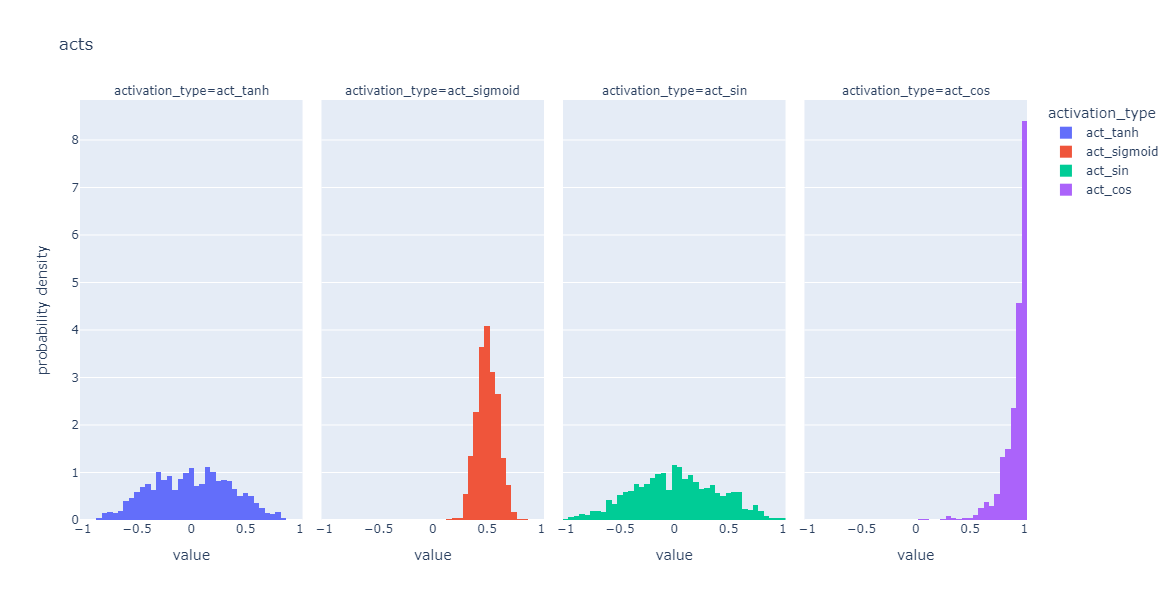

In [86]:
x, preact, preact_tanh, preact_sigmoid, preact_sin, preact_cos, act_tanh, act_sigmoid, act_sin, act_cos = acts

preact_tanh = to_np(preact_tanh)
preact_sigmoid = to_np(preact_sigmoid)
preact_sin = to_np(preact_sin)
preact_cos = to_np(preact_cos)
act_tanh = to_np(act_tanh)
act_sigmoid = to_np(act_sigmoid)
act_sin = to_np(act_sin)
act_cos = to_np(act_cos)

# Create a dataframe from your arrays
data = {
    # "preact_tanh": preact_tanh,
    # "preact_sigmoid": preact_sigmoid,
    # "preact_sin": preact_sin,
    # "preact_cos": preact_cos,
    "act_tanh": act_tanh,
    "act_sigmoid": act_sigmoid,
    "act_sin": act_sin,
    "act_cos": act_cos,
}

df = pd.DataFrame(data)

# Melt the dataframe to a long format for easier plotting
df_melted = df.melt(var_name="activation_type", value_name="value")

# Plot histograms using Plotly Express
fig = px.histogram(
    df_melted,
    x="value",
    color="activation_type",
    facet_col="activation_type",
    facet_col_wrap=4,
    histnorm="probability density",
    title=title,
)

fig.update_layout(
    autosize=False,
    width=1000,
    height=600,
)

# fig.update_yaxes(range=[0, 1.5])

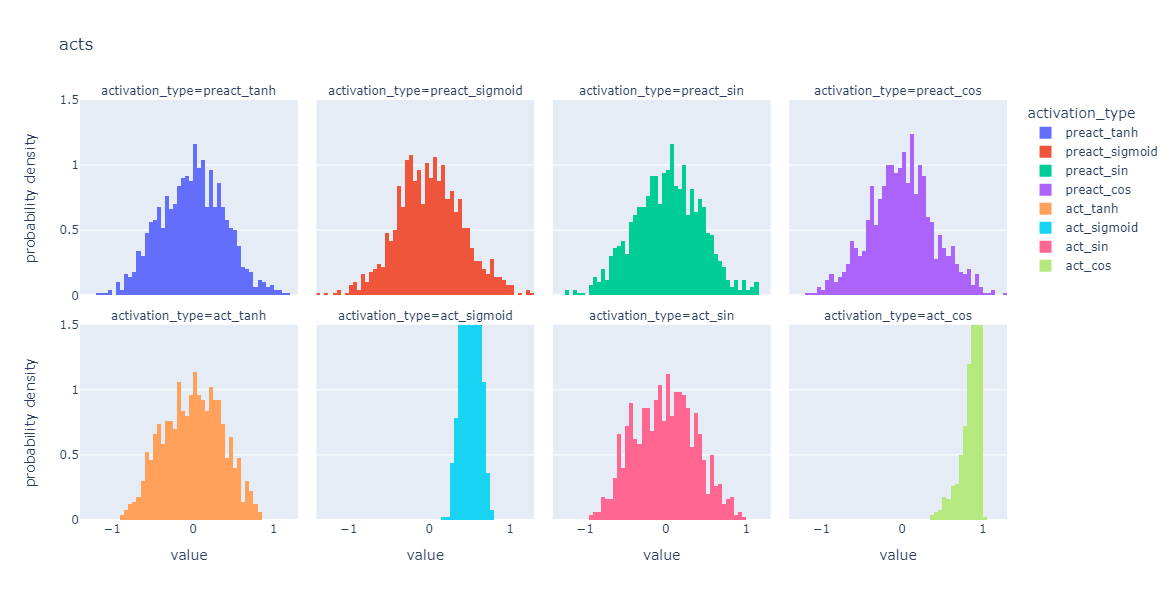

In [87]:
plot_acts(layer1_acts)

In [88]:
class SimpleSplitNet:
    def init(self, in_size=encoded_size*2, out_size=3, hsize=512, ):
        W1, b1 = init_splitact_Wb(encoded_size*2, hsize, device)
        W2, b2 = init_splitact_Wb(hsize, hsize, device)
        W3, b3 = init_splitact_Wb(hsize, out_size, device)

        parameters = [W1, b1, W2, b2, W3, b3]
        # print(sum(p.nelement() for p in parameters)) # number of parameters in total
        for p in parameters:
            p.requires_grad = True
            
        self.parameters = parameters
        return self

        
    def to(self, *args, **kwargs):
        for i, p in enumerate(self.parameters):
            self.parameters[i] = p.to(*args, **kwargs)
        return self
    

    def raw_forward(self, x, params=None):
        if params is None:
            params = self.parameters

        bs = x.shape[0]
        W1, b1, W2, b2, W3, b3 = params

        h1, layer1_acts = splitlayer_forward(x, W1, b1)
        h2, layer2_acts = splitlayer_forward(h1, W2, b2)
        model_output, layer3_acts = splitlayer_forward(h2, W3, b3)
        
        return model_output, [layer1_acts, layer2_acts, layer3_acts]

In [122]:
net = SimpleSplitNet().init().to(device)
net.parameters[2] = net.parameters[2] * 40.
net.parameters[4] = net.parameters[4] * 40.

In [120]:
net.parameters[4]

tensor[512, 12] n=6144 x∈[-0.442, 0.442] μ=0.004 σ=0.255 grad MulBackward0 cuda:1

In [121]:
net.parameters[2]

tensor[512, 2048] n=1048576 x∈[-0.442, 0.442] μ=-8.361e-05 σ=0.255 grad MulBackward0 cuda:1

In [123]:
model_output, interim_acts = net.raw_forward(x_enc)

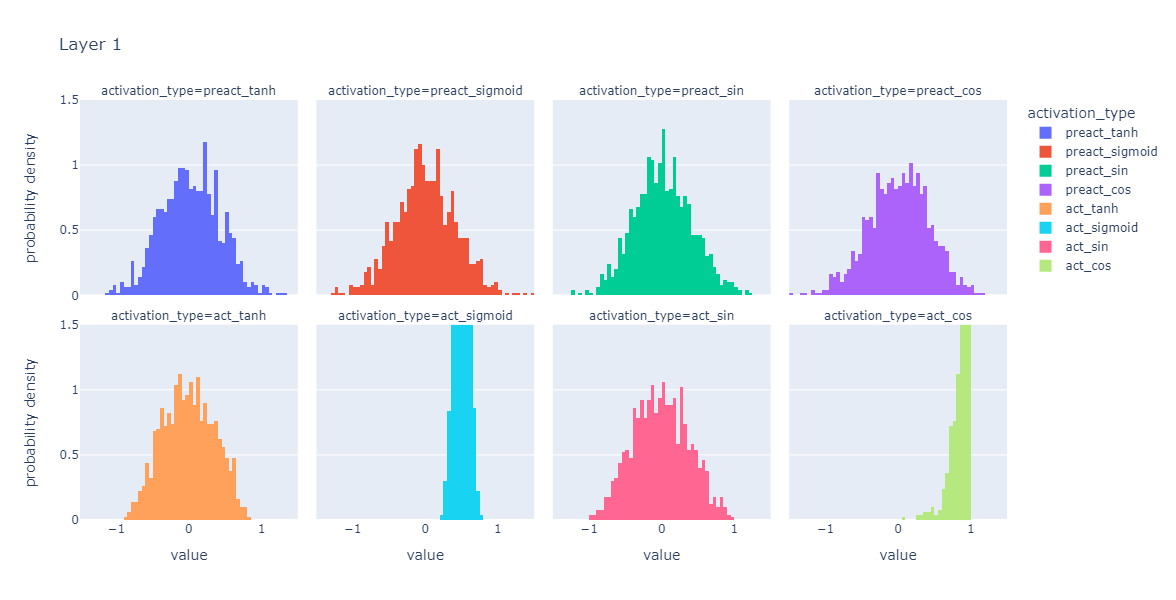

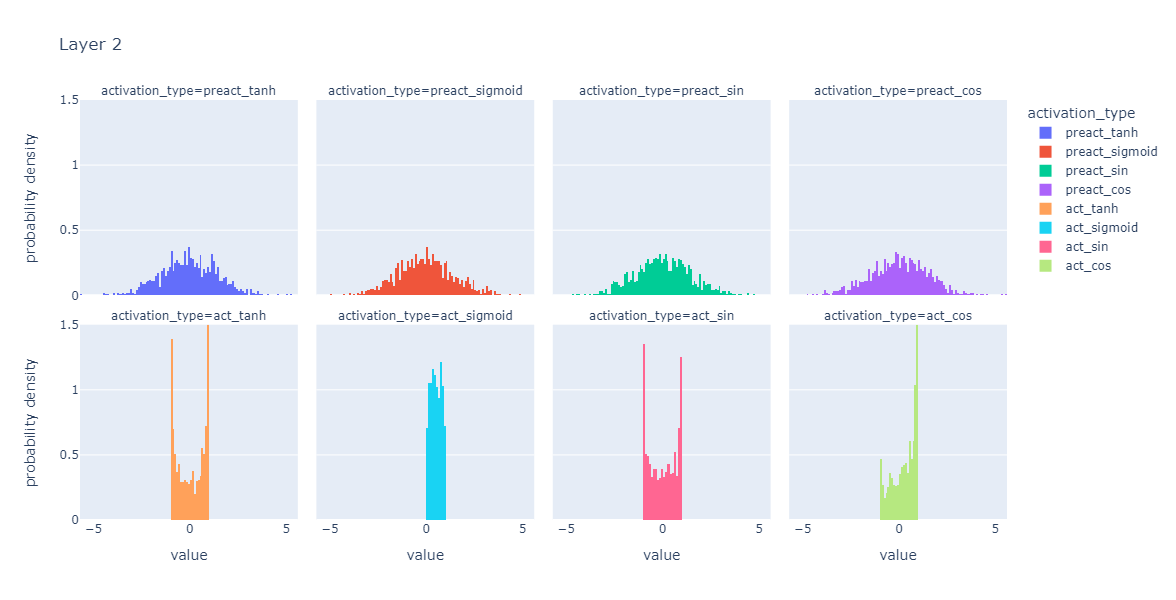

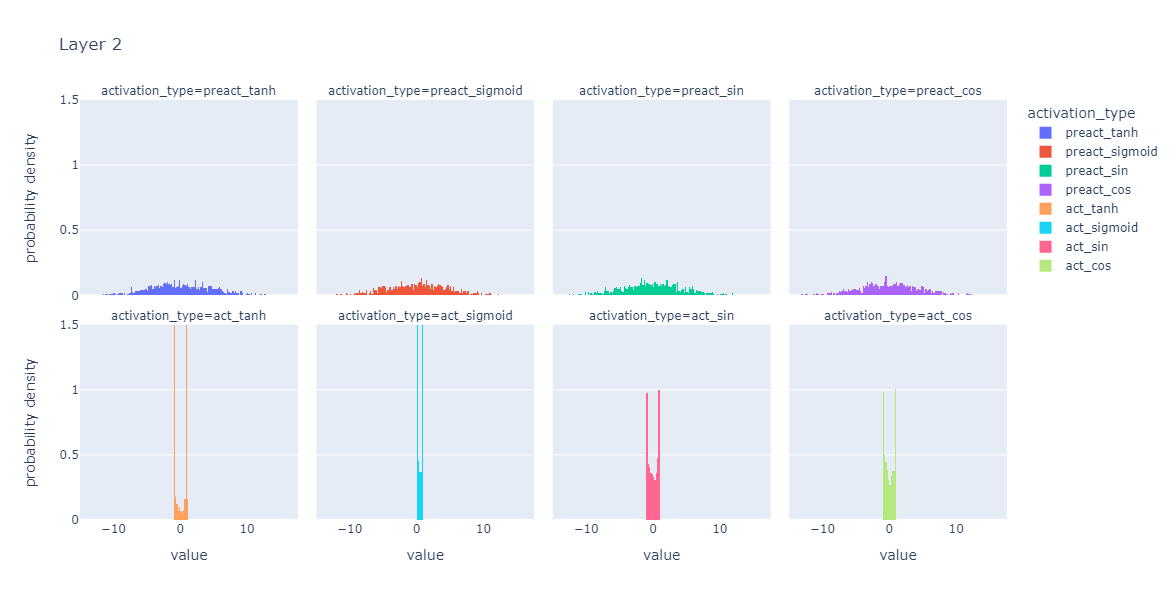

In [124]:
plot_acts(interim_acts[0], 'Layer 1')

plot_acts(interim_acts[1], 'Layer 2')

plot_acts(interim_acts[2], 'Layer 2')